## Mount Drive

In [ ]:
#Use this if you're using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Please change this according to your folder shortcut that refers to "TK2-DatMin" directory (colab). Leave it as it is if you run this on local
BASE_DIR = '.'

In [ ]:
#Data input paths
dataset_path = BASE_DIR+'/spotify_full.csv'
graph_path = BASE_DIR+'/spotify.gexf'

In [ ]:
#Ignore logging warnings
import warnings
warnings.filterwarnings('ignore') 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def classification_report_and_confusion_matrix(pred, y_test):  
  print(classification_report(pred, y_test, digits=4))
  print('roc_auc:', roc_auc_score(pred, y_test))
  print('f1:', f1_score(pred, y_test))
  conf = confusion_matrix(pred, y_test, normalize='true')
  confnum = confusion_matrix(pred, y_test)

  sns.heatmap(conf, annot=confnum, 
              fmt='.2f',cmap='Blues')
  plt.title(f'Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

In [ ]:
!pip install networkx

## Cross Validation Evaluation

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

def eval_models(dataset, models, folds=5):
    kf = KFold(n_splits=folds)
    
    auc_score_res = dict()
    f1_score_res = dict()
    
    for train_index, test_index in kf.split(dataset):
        train_dataset = dataset.iloc[train_index,:]
        test_dataset = dataset.iloc[test_index,:]
        y_eval = np.array(test_dataset['isConnected'].values)
        for model_name, model in models.items():
            
            model.initialize(train_dataset, model.num_walks, model.num_steps, model.p, model.q)
            model.fit()
            res = model.predict(test_dataset)
            
            #save the score
            for model_variation, model_pred in res.items():
                current_model_name = model_name+" "+model_variation

                if current_model_name not in auc_score_res:
                    auc_score_res[current_model_name] = []
                if current_model_name not in f1_score_res:
                    f1_score_res[current_model_name] = []

                auc_score_res[current_model_name].append(roc_auc_score(y_eval, model_pred))
                f1_score_res[current_model_name].append(f1_score(y_eval, model_pred))
    
    for key, value in auc_score_res.items():
        auc_score_res[key] = sum(value)/len(value)
    
    for key, value in f1_score_res.items():
        f1_score_res[key] = sum(value)/len(value)
    
    return auc_score_res, f1_score_res

## Model Interface

In [ ]:
import networkx as nx

class BaseModel:
    def build_graph(self, df):
        self.df = df
        adj_df = df[df['isConnected']==True]
        self.graph = nx.Graph()
        for i, row in adj_df.iterrows():
            self.graph.add_edge(row['Artist1'], row['Artist2'], weight=row['weight'])
        
    def fit(self, X, y):
        raise NotImplementedError
    
    def predict(self) -> dict:
        raise NotImplementedError

## Node2Vec

In [ ]:
!pip install -U gensim

     |████████████████████████████████| 24.1 MB 72.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import random
from gensim.models import Word2Vec

#Reference: https://keras.io/examples/graph/node2vec_movielens/
class Node2Vec(BaseModel):    
    def __init__(self, df, num_walks, num_steps, p, q, clfs):
        self.num_walks = num_walks
        self.num_steps = num_steps
        self.p = p
        self.q = q
        self.clfs = {
            'hadamard': clfs[0],
            'l1': clfs[1],
            'l2': clfs[2],
            'avg': clfs[3]
        }
        self.initialize(df, num_walks, num_steps,p, q)
    
    def initialize(self, df, num_walks, num_steps, p, q):
        self.build_graph(df)
        self.artists = list(self.graph.nodes())
        self.artist2idx = {artist: str(idx) for idx, artist in enumerate(self.artists)}
        self.idx2artist = {idx: artist for idx, artist in self.artist2idx.items()}
        self.node_embeddings = self.__generate_node_embeddings(num_walks, num_steps, p, q)
    
        
    def __do_walk(self, prev, current, p, q):
        adj_list = list(self.graph.neighbors(current))

        probas = []
        for nxt in adj_list:
            if nxt ==  prev:
                probas.append(self.graph[current][nxt]['weight']/p)
            #has edge from previous node 
            elif self.graph.has_edge(prev, nxt):
                probas.append(self.graph[current][nxt]['weight'])
            else:
                probas.append(self.graph[current][nxt]['weight']/q)
        total_proba = sum(probas)
        normalized_probas = [proba/total_proba for proba in probas]
        choosen_nxt = np.random.choice(adj_list, size=1, p=normalized_probas)[0]
        return choosen_nxt

    def __random_walk(self, num_walks, num_steps, p, q):
        walks_record = []
        nodes = list(self.graph.nodes())

        for walk_step in range(num_walks):
            random.shuffle(nodes)

            for node in nodes:
                walk_record = [node]
                while len(walk_record) < num_steps:
                    current = walk_record[-1]
                    prev = walk_record[-2] if len(walk_record) > 1 else ""
                    dest =  self.__do_walk(prev, current, p, q)
                    walk_record.append(dest)

                #encode as idx or integer to ignore whitespace
                walk_record = [self.artist2idx[token] for token in walk_record]
                walks_record.append(walk_record)

        return walks_record

    def __generate_node_embeddings(self, num_walks, num_steps, p, q):
        walks_record = self.__random_walk(num_walks, num_steps, p, q)
        model = Word2Vec(walks_record, vector_size=128, window=5, min_count=0, sg=1, workers=2, epochs=1)
        node_embedding = {node : model.wv[self.artist2idx[node]] for node in self.artists}
        return node_embedding

    def __hadamard(self, u, v):
        return u * v
    
    def __l1(self, u, v):
        return np.abs(u - v)
    
    def __l2(self, u, v):
        return (u - v) ** 2
    
    def __avg(self, u, v):
        return (u + v) / 2.0
    
    def __preprocess_df(self, df):
        X_h, X_l1, X_l2, X_avg, y = [], [], [], [], []
        for _, row in df.iterrows():
            node1_embedding = self.node_embeddings[row['Artist1']] if row['Artist1'] in self.node_embeddings else np.array([0]*len(list(self.node_embeddings.values())[0]))
            node2_embedding = self.node_embeddings[row['Artist2']] if row['Artist2'] in self.node_embeddings else np.array([0]*len(list(self.node_embeddings.values())[0]))
            row_h = self.__hadamard(node1_embedding, node2_embedding)
            row_l1 = self.__l1(node1_embedding, node2_embedding)
            row_l2 = self.__l2(node1_embedding, node2_embedding)
            row_avg = self.__avg(node1_embedding, node2_embedding)
            row_y = np.array([int(row['isConnected'])])
            
            X_h.append(row_h)
            X_l1.append(row_l1)
            X_l2.append(row_l2)
            X_avg.append(row_avg)
            y.append(row_y)
        return np.array(X_h), np.array(X_l1), np.array(X_l2), np.array(X_avg), np.array(y)
    
    def fit(self):
        train_df = self.df.drop('weight', axis=1)
        X_h, X_l1, X_l2, X_avg, y = self.__preprocess_df(train_df)
            
        #train separate classifiers
        self.clfs['hadamard'].fit(X_h, y)
        self.clfs['l1'].fit(X_l1, y)
        self.clfs['l2'].fit(X_l2, y)
        self.clfs['avg'].fit(X_avg, y)
    
    def predict(self, test_df) -> dict:
        test_df.drop('weight', axis=1, inplace=True)
        X_h, X_l1, X_l2, X_avg, _ = self.__preprocess_df(test_df)
        return {
            'hadamard': self.clfs['hadamard'].predict(X_h),
            'l1': self.clfs['l1'].predict(X_l1),
            'l2': self.clfs['l2'].predict(X_l2),
            'avg': self.clfs['avg'].predict(X_avg)
        }
    
    
    def predict_eval(self, test_df, op):
        if 'weight' in test_df.columns:
            test_df.drop('weight', axis=1, inplace=True)
        X_h, X_l1, X_l2, X_avg, y = self.__preprocess_df(test_df)
        X_dict = {
            'hadamard': X_h,
            'l1': X_l1,
            'l2': X_l2,
            'avg': X_avg
        }
        y_pred = self.clfs[op].predict(X_dict[op])
        classification_report_and_confusion_matrix(y_pred, y)

In [ ]:
import pandas as pd
spotify_df = pd.read_csv(dataset_path)

### Node2Vec Hyperparameter Selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

p_lst = [1,2,4]
q_lst = [1,2,4]
num_walks = [8]
num_steps = [20]

best_p, best_q, best_num_walk, best_num_step = 0,0,0,0
best_score = 0.0
for p in p_lst:
    for q in q_lst:
        for num_walk in num_walks:
            for num_step in num_steps:
                clfs = [LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()]     
                node2vec = Node2Vec(spotify_df,num_walk, num_step, p, q, clfs)
                models = {
                    'node2vec': node2vec
                }
                _, f1 = eval_models(spotify_df, models)
                f1_mean = 0.0
                for _, value in f1.items():
                    f1_mean += value
                f1_mean /= len(list(f1.items()))
                if f1_mean > best_score:
                    best_p = p
                    best_q = q
                    best_score = f1_mean
                    best_num_walk = num_walk
                    best_num_step = num_step
                    
print(f'Best p: {best_p}')
print(f'Best q: {best_q}')
print(f'Best num walk: {best_num_walk}')
print(f'Best num step: {best_num_step}')
clfs = [LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()]                    
node2vec = Node2Vec(spotify_df,best_num_walk, best_num_step, best_p, best_q, clfs)

models = {
    'node2vec': node2vec
}
auc, f1 = eval_models(spotify_df, models)

Best p: 2
Best q: 1
Best num walk: 8
Best num step: 20


In [ ]:
f1

{'node2vec hadamard': 0.6212456027745075,
 'node2vec l1': 0.7656845222127202,
 'node2vec l2': 0.7763822907981892,
 'node2vec avg': 0.4195957459119114}

In [ ]:
auc

{'node2vec hadamard': 0.7191171560845853,
 'node2vec l1': 0.8047782986131296,
 'node2vec l2': 0.8097748824858566,
 'node2vec avg': 0.48012531672240943}

### Node2Vec Model Testing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
best_model = LogisticRegression
best_score = 0.0
models = {'logreg':LogisticRegression, 'adaboost': AdaBoostClassifier, 'randomforest':RandomForestClassifier, 'mlp': MLPClassifier}
for model_name, model in models.items():
    clfs = [model(), model(), model(), model()]     
    node2vec = Node2Vec(spotify_df,best_num_walk, best_num_step, best_p, best_q, clfs)
    models = {
        'node2vec': node2vec
    }
    auc, f1 = eval_models(spotify_df, models)
    score = sum(f1.values())/len(f1.values())
    if score > best_score:
        best_score = score
        best_model = model
    print(model_name)
    print(f'roc-auc: {auc}')
    print(f'f1: {f1}')
    print()

logreg
roc-auc: {'node2vec hadamard': 0.7216232637454931, 'node2vec l1': 0.8034444520495153, 'node2vec l2': 0.8084339485862806, 'node2vec avg': 0.48268836882292254}
f1: {'node2vec hadamard': 0.6265513540674994, 'node2vec l1': 0.7642983469687616, 'node2vec l2': 0.7745087619570554, 'node2vec avg': 0.4167929728503544}

adaboost
roc-auc: {'node2vec hadamard': 0.7208089362543673, 'node2vec l1': 0.7101829013713608, 'node2vec l2': 0.7126587984903953, 'node2vec avg': 0.673259166447409}
f1: {'node2vec hadamard': 0.6210165161177968, 'node2vec l1': 0.6044089210911686, 'node2vec l2': 0.6085467993533953, 'node2vec avg': 0.5813838293602005}

randomforest
roc-auc: {'node2vec hadamard': 0.719370772804701, 'node2vec l1': 0.7011092174010681, 'node2vec l2': 0.7020039842313628, 'node2vec avg': 0.7213854881123576}
f1: {'node2vec hadamard': 0.6148342849664875, 'node2vec l1': 0.581677046299472, 'node2vec l2': 0.5839698194741403, 'node2vec avg': 0.6391426659140307}

mlp
roc-auc: {'node2vec hadamard': 0.729793

### Model Error Analysis

              precision    recall  f1-score   support

           0     0.9273    0.7234    0.8127       282
           1     0.6195    0.8881    0.7299       143

    accuracy                         0.7788       425
   macro avg     0.7734    0.8058    0.7713       425
weighted avg     0.8237    0.7788    0.7849       425

roc_auc: 0.8057580717155185
f1: 0.7298850574712644


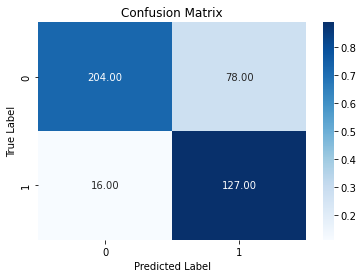

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spotify_df, test_size=0.35)

clfs = [LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()]     
node2vec = Node2Vec(train,best_num_walk, best_num_step, best_p, best_q, clfs)
node2vec.fit()
node2vec.predict_eval(test, 'l2')

              precision    recall  f1-score   support

           0     0.9773    0.6287    0.7651       342
           1     0.3805    0.9398    0.5417        83

    accuracy                         0.6894       425
   macro avg     0.6789    0.7842    0.6534       425
weighted avg     0.8607    0.6894    0.7215       425

roc_auc: 0.7842070034524061
f1: 0.5416666666666667


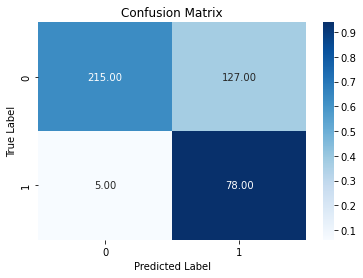

In [ ]:
clfs = [AdaBoostClassifier(), AdaBoostClassifier(), AdaBoostClassifier(), AdaBoostClassifier()]     
node2vec = Node2Vec(train,best_num_walk, best_num_step, best_p, best_q, clfs)
node2vec.fit()
node2vec.predict_eval(test, 'l2')

              precision    recall  f1-score   support

           0     0.9909    0.6264    0.7676       348
           1     0.3659    0.9740    0.5319        77

    accuracy                         0.6894       425
   macro avg     0.6784    0.8002    0.6498       425
weighted avg     0.8777    0.6894    0.7249       425

roc_auc: 0.8002313778175846
f1: 0.5319148936170213


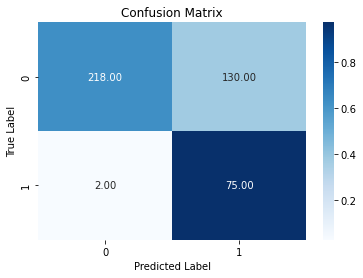

In [ ]:
clfs = [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()]     
node2vec = Node2Vec(train,best_num_walk, best_num_step, best_p, best_q, clfs)
node2vec.fit()
node2vec.predict_eval(test, 'l2')

              precision    recall  f1-score   support

           0     0.9500    0.7207    0.8196       290
           1     0.6049    0.9185    0.7294       135

    accuracy                         0.7835       425
   macro avg     0.7774    0.8196    0.7745       425
weighted avg     0.8404    0.7835    0.7910       425

roc_auc: 0.8196040868454662
f1: 0.7294117647058823


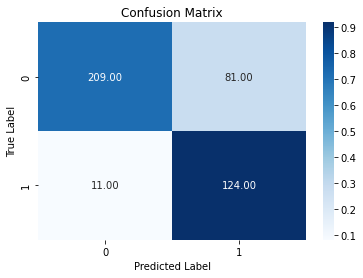

In [ ]:
clfs = [MLPClassifier(), MLPClassifier(), MLPClassifier(), MLPClassifier()]     
node2vec = Node2Vec(train,best_num_walk, best_num_step, best_p, best_q, clfs)
node2vec.fit()
node2vec.predict_eval(test, 'l2')

# Link Feature-Based Prediction

In [ ]:
spotify_df

,Artist1,Artist2,weight,isConnected
0,2 Chainz,MadeinTYO,1,True
1,SHIMA,Sumire,1,True
2,Khalid,Logic,1,True
3,Drake,The Weeknd,1,True
4,Pierce The Veil,Rich Homie Quan,0,False
...,...,...,...,...
1209,Chase Rice,Florida Georgia Line,1,True
1210,Hal David,John Barry,1,True
1211,Atmozfears,Craig David,0,False
1212,Kaidro,SZA,0,False


In [ ]:
class GraphModel(BaseModel):
  def __init__(self, df):
    self.initialize(df)

  def initialize(self, df):
    self.build_graph(df)
    self.artists = list(self.graph.nodes())
    self.artist2idx = {artist: str(idx) for idx, artist in enumerate(self.artists)}
    self.idx2artist = {idx: artist for idx, artist in self.artist2idx.items()}

  def predict(self, test):
    return nx.jaccard_coefficient(self.graph, test)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
spotify_df_prec = spotify_df.copy()
artist_list = np.concatenate((spotify_df['Artist1'].to_numpy(), spotify_df['Artist2'].to_numpy()))
le.fit(artist_list)

spotify_df_prec['Artist1'] = le.transform(spotify_df['Artist1'])
spotify_df_prec['Artist2'] = le.transform(spotify_df['Artist2'])
spotify_df_prec['isConnected'] = le.fit_transform(spotify_df['isConnected'])
spotify_df_prec

,Artist1,Artist2,weight,isConnected
0,1,322,1,1
1,442,479,1,1
2,268,308,1,1
3,134,506,1,1
4,401,425,0,0
...,...,...,...,...
1209,80,161,1,1
1210,188,233,1,1
1211,35,97,0,0
1212,254,445,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X = spotify_df_prec.drop(['weight', "isConnected"], axis=1).to_numpy()
y = spotify_df_prec['isConnected'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
gb = GradientBoostingClassifier()

gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('roc-auc:', roc_auc_score(pred, y_test))
print('f1:', f1_score(pred, y_test))

roc-auc: 0.4861183865898376
f1: 0.4583333333333333


In [ ]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print('roc-auc:', roc_auc_score(pred, y_test))
print('f1:', f1_score(pred, y_test))

roc-auc: 0.48399825594070195
f1: 0.5015873015873016


In [ ]:
X = spotify_df_prec
y = spotify_df_prec['isConnected'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
graph = GraphModel(spotify_df_prec)

In [ ]:
edges = X_train.to_numpy()[:, :3]
g = nx.function.create_empty_copy(graph.graph)
g.add_weighted_edges_from(edges)

In [ ]:
X_train = X_train.drop(['isConnected', "weight"], axis=1)
X_test = X_test.drop(['isConnected', "weight"], axis=1)

In [ ]:
from sklearn.preprocessing import minmax_scale
def create_link_features(X_train, X_test, graph):
  aa_train = np.array(list(nx.adamic_adar_index(graph, X_train.to_numpy())))[:, 2]
  aa_test = np.array(list(nx.adamic_adar_index(graph, X_test.to_numpy())))[:, 2]
  jc_train = np.array(list(nx.jaccard_coefficient(graph, X_train.to_numpy())))[:, 2]
  jc_test = np.array(list(nx.jaccard_coefficient(graph, X_test.to_numpy())))[:, 2]
  pa_train = np.array(list(nx.preferential_attachment(graph, X_train.to_numpy())))[:, 2]
  pa_test = np.array(list(nx.preferential_attachment(graph, X_test.to_numpy())))[:, 2]
  ra_train = np.array(list(nx.resource_allocation_index(graph, X_train.to_numpy())))[:, 2]
  ra_test = np.array(list(nx.resource_allocation_index(graph, X_test.to_numpy())))[:, 2]

  sim = nx.simrank_similarity(graph)
  sim_test = list()
  for x in X_test.to_numpy():
    sim_test.append(sim[x[0]][x[1]])

  sim_train = list()
  for x in X_train.to_numpy():
    sim_train.append(sim[x[0]][x[1]])


  cn_test = list()
  for x in X_test.to_numpy():
    cn_test.append(len(list(nx.common_neighbors(graph, x[0], x[1]))))

  cn_train = list()
  for x in X_train.to_numpy():
    cn_train.append(len(list(nx.common_neighbors(graph, x[0], x[1]))))
    
  X_train['aa'] = aa_train
  X_test['aa'] = aa_test
  X_train['jc'] = jc_train
  X_test['jc'] = jc_test
  X_train['sim'] = sim_train
  X_test['sim'] = sim_test
  X_train['cn'] = minmax_scale(cn_train)
  X_test['cn'] = minmax_scale(cn_test)
  X_train['pa'] = minmax_scale(pa_train)
  X_test['pa'] = minmax_scale(pa_test)
  X_train['ra'] = ra_train
  X_test['ra'] = ra_test

In [ ]:
create_link_features(X_train, X_test, g)
X_train = X_train.drop(['Artist1', 'Artist2'], axis=1)
X_test = X_test.drop(['Artist1', 'Artist2'], axis=1)

In [ ]:
gb = GradientBoostingClassifier()

gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('roc-auc:', roc_auc_score(pred, y_test))
print('f1:', f1_score(pred, y_test))

roc-auc: 0.7896656534954407
f1: 0.6885245901639345


In [ ]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print('roc-auc:', roc_auc_score(pred, y_test))
print('f1:', f1_score(pred, y_test))

roc-auc: 0.7930680885972108
f1: 0.6859504132231404


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(verbose=False)

cb.fit(X_train, y_train)
pred = cb.predict(X_test)
print('roc-auc:', roc_auc_score(pred, y_test))
print('f1:', f1_score(pred, y_test))

roc-auc: 0.7973657548125633
f1: 0.6967213114754099


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

def eval_model_(dataset, models, folds=5):
    kf = KFold(n_splits=folds)
    
    auc_score_res = dict()
    f1_score_res = dict()
    
    for train_index, test_index in kf.split(dataset):
        train_dataset = dataset.iloc[train_index,:]
        test_dataset = dataset.iloc[test_index,:]

        X_train = train_dataset.drop(['isConnected', "weight"], axis=1)
        X_test = test_dataset.drop(['isConnected', "weight"], axis=1)
        y_train = np.array(train_dataset['isConnected'].values)
        y_eval = np.array(test_dataset['isConnected'].values)

        edges = train_dataset.to_numpy()[:, :3]
        g = nx.function.create_empty_copy(graph.graph)
        g.add_weighted_edges_from(edges)
        
        create_link_features(X_train, X_test, g)
        X_train = X_train.drop(['Artist1', 'Artist2'], axis=1)
        X_test = X_test.drop(['Artist1', 'Artist2'], axis=1)

        for model_name in models:
          model = models[model_name]
          model.fit(X_train, y_train)
          res = model.predict(X_test)
          
          current_model_name = model_name

          if current_model_name not in auc_score_res:
              auc_score_res[current_model_name] = []
          if current_model_name not in f1_score_res:
              f1_score_res[current_model_name] = []

          auc_score_res[current_model_name].append(roc_auc_score(y_eval, res))
          f1_score_res[current_model_name].append(f1_score(y_eval, res))
    
    for key, value in auc_score_res.items():
        auc_score_res[key] = sum(value)/len(value)
    
    for key, value in f1_score_res.items():
        f1_score_res[key] = sum(value)/len(value)
    
    return auc_score_res, f1_score_res

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

cb = CatBoostClassifier(verbose=False)
gb = GradientBoostingClassifier()
rfc = RandomForestClassifier()
gnb = GaussianNB()
knn = KNeighborsClassifier()

models = {
    'catboost': cb,
    'gradientboost': gb,
    'randomforest': rfc,
    'gnb': gnb,
    'knn': knn
}

auc, f1 = eval_model_(spotify_df_prec, models)
print(dict(sorted(f1.items(), reverse=True, key=lambda item: item[1])))
print(dict(sorted(auc.items(), reverse=True, key=lambda item: item[1])))

{'catboost': 0.7494651996531043, 'gradientboost': 0.7465124435533961, 'knn': 0.7443969735218093, 'randomforest': 0.7442416126299335, 'gnb': 0.6550479151595167}
{'catboost': 0.7732839844974148, 'gradientboost': 0.771678675146046, 'randomforest': 0.7706893290880787, 'knn': 0.7601024194155477, 'gnb': 0.7296308071556012}


In [ ]:
colname = list(X_train.columns.copy())
colname[colname.index('aa')] = 'Adamic-Adar'
colname[colname.index('sim')] = 'SimRank'
colname[colname.index('jc')] = 'Jaccard Coefficient'
colname[colname.index('ra')] = 'Resource Allocation Index'
colname[colname.index('cn')] = 'Common Neighbours'
colname[colname.index('pa')] = 'Preferential Attachment'
colname = np.array(colname)

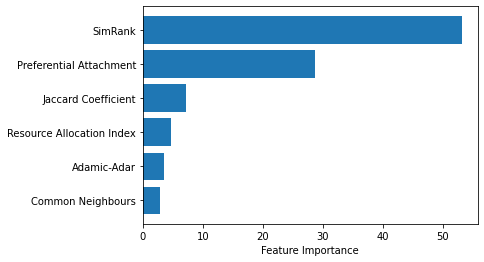

In [ ]:
sorted_idx = cb.feature_importances_.argsort()
plt.barh(colname[sorted_idx], cb.feature_importances_[sorted_idx])

# for a,b in zip(colname[sorted_idx], cb.feature_importances_[sorted_idx]):
#   plt.text(b, a, str(round(b, 2)))
plt.xlabel("Feature Importance")
plt.show()

In [ ]:
def create_train_test_dataset(X, y, train_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-train_size), random_state=42)
  graph = GraphModel(spotify_df_prec)
  edges = X_train.to_numpy()[:, :3]
  g = nx.function.create_empty_copy(graph.graph)
  g.add_weighted_edges_from(edges)
  X_train = X_train.drop(['isConnected', "weight"], axis=1)
  X_test = X_test.drop(['isConnected', "weight"], axis=1)

  create_link_features(X_train, X_test, g)
  X_train = X_train.drop(['Artist1', 'Artist2'], axis=1)
  X_test = X_test.drop(['Artist1', 'Artist2'], axis=1)

  return X_train, X_test, y_train, y_test

In [ ]:
roc_list = []
f1_list = []
train_size_list = [0.65, 0.75, 0.85, 0.95]

for train_size in train_size_list:
  X_train, X_test, y_train, y_test = create_train_test_dataset(X, y, train_size)
  cb = CatBoostClassifier(verbose=False)
  cb.fit(X_train, y_train)
  pred = cb.predict(X_test)

  roc_list.append(roc_auc_score(pred, y_test))
  f1_list.append(f1_score(pred, y_test))

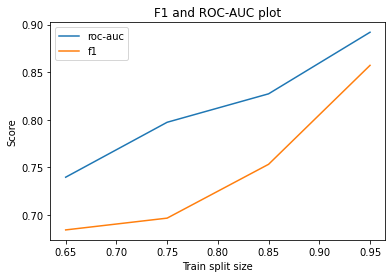

In [ ]:
plt.plot(train_size_list, roc_list, label='roc-auc')
plt.plot(train_size_list, f1_list, label='f1')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Train split size')
plt.title('F1 and ROC-AUC plot')
plt.show()

              precision    recall  f1-score   support

           0     0.8592    0.6629    0.7484       267
           1     0.5890    0.8165    0.6844       158

    accuracy                         0.7200       425
   macro avg     0.7241    0.7397    0.7164       425
weighted avg     0.7588    0.7200    0.7246       425

roc_auc: 0.7396885222585693
f1: 0.6843501326259946


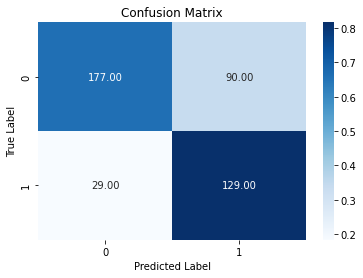

In [ ]:
X_train, X_test, y_train, y_test = create_train_test_dataset(X, y, 0.65)
cb = CatBoostClassifier(verbose=False)
cb.fit(X_train, y_train)
pred = cb.predict(X_test)

classification_report_and_confusion_matrix(pred, y_test)

              precision    recall  f1-score   support

           0     0.8689    0.6557    0.7474       273
           1     0.5708    0.8224    0.6739       152

    accuracy                         0.7153       425
   macro avg     0.7199    0.7390    0.7106       425
weighted avg     0.7623    0.7153    0.7211       425

roc_auc: 0.7390230383651436
f1: 0.6738544474393531


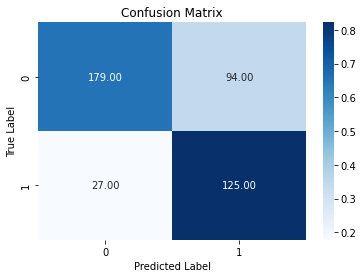

In [ ]:
X_train, X_test, y_train, y_test = create_train_test_dataset(X, y, 0.65)
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
pred = gb.predict(X_test)

classification_report_and_confusion_matrix(pred, y_test)

              precision    recall  f1-score   support

           0     0.8592    0.6580    0.7453       269
           1     0.5799    0.8141    0.6773       156

    accuracy                         0.7153       425
   macro avg     0.7196    0.7360    0.7113       425
weighted avg     0.7567    0.7153    0.7203       425

roc_auc: 0.7360475645791631
f1: 0.6773333333333333


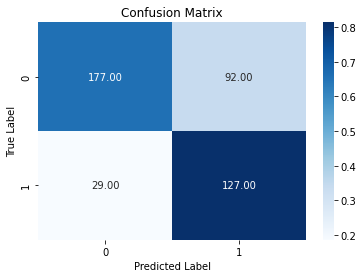

In [ ]:
X_train, X_test, y_train, y_test = create_train_test_dataset(X, y, 0.65)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

classification_report_and_confusion_matrix(pred, y_test)

              precision    recall  f1-score   support

           0     0.7573    0.6695    0.7107       233
           1     0.6484    0.7396    0.6910       192

    accuracy                         0.7012       425
   macro avg     0.7028    0.7046    0.7009       425
weighted avg     0.7081    0.7012    0.7018       425

roc_auc: 0.7045556151645207
f1: 0.6909975669099756


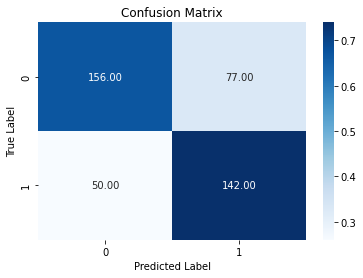

In [ ]:
X_train, X_test, y_train, y_test = create_train_test_dataset(X, y, 0.65)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

classification_report_and_confusion_matrix(pred, y_test)

              precision    recall  f1-score   support

           0     0.8932    0.5993    0.7173       307
           1     0.4384    0.8136    0.5697       118

    accuracy                         0.6588       425
   macro avg     0.6658    0.7065    0.6435       425
weighted avg     0.7669    0.6588    0.6764       425

roc_auc: 0.7064539281179264
f1: 0.56973293768546


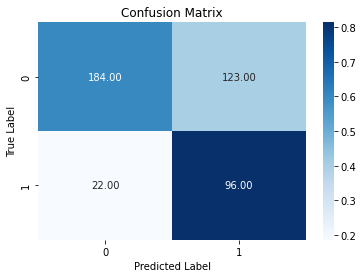

In [ ]:
X_train, X_test, y_train, y_test = create_train_test_dataset(X, y, 0.65)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)

classification_report_and_confusion_matrix(pred, y_test)

# GNN 

In [ ]:
!pip install --upgrade torch-scatter
!pip install --upgrade torch-sparse
!pip install --upgrade torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [ ]:
import copy
import torch
import torch.nn as nn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv

#reference: https://colab.research.google.com/drive/1AjLbfuz9qXE5yglPOifUKhOHkzAuHmOF?usp=sharing
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, conv, dropout=0.2):
        super(GNNModel, self).__init__()
        
        self.conv1 = conv(input_dim, hidden_dim)
        self.conv2 = conv(hidden_dim, num_classes)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.dropout = dropout
    

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index

        out = self.conv1(node_feature, edge_index)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout)
        out = self.conv2(out, edge_index)
        out = out[edge_label_index[0]] * out[edge_label_index[1]]
        pred = torch.sum(out, -1)
        return pred
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

class GNNFactory():
    def create_gnn(self, conv_type, params):
        if conv_type=='GCN':
            conv_layer = GCNConv
        elif conv_type=='SAGE':
            conv_layer = SAGEConv
        else:
            conv_layer = GATConv
        return GNNModel(params['input_dim'], params['hidden_dim'], params['num_classes'], conv_layer, params['dropout'])

gnn_factory = GNNFactory()


In [ ]:
from sklearn.metrics import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

def train (model, dataloaders, optimizer, args):
  best_score = -1
  best_model = model
  train_scores = []
  val_scores = []
  epochs = [i+1 for i in range(args['n_epochs'])]
  for epoch in range(args['n_epochs']):
    train_score_mean = 0.0
    val_score_mean = 0.0
    freq = 0
    for step, batch in enumerate(dataloaders['train']):
       batch.to(args["device"])
       optimizer.zero_grad()
       prediction = model(batch)
       loss = model.loss(prediction, batch.edge_label.float())
       loss.backward()
       optimizer.step()
       train_score = test(model, dataloaders['train'], args)
       val_score = test(model, dataloaders['val'], args)
       train_score_mean += train_score
       val_score_mean += val_score
       freq += 1
       if best_score < val_score:
         best_score = val_score
         best_model = copy.deepcopy(model)
    train_scores.append(train_score_mean)
    val_scores.append(val_score_mean)
  plt.plot(epochs, train_scores, label='Training F1 score')
  plt.plot(epochs, val_scores, label='Validation F1 score')
  plt.xlabel('epoch')
  plt.ylabel('F1 score')
  plt.legend()
  plt.show()
  return best_model

def test(model, dataloader, args):
  model.eval()

  f1,roc_auc = 0.0, 0.0

  for step, batch in enumerate(dataloader):
    batch.to(args["device"])
    prediction = model(batch)
    prediction = torch.sigmoid(prediction)
    f1 += f1_score(np.rint(batch.edge_label.cpu().detach().numpy()).astype(int), np.rint(prediction.cpu().detach().numpy()).astype(int))
  f1/=len(dataloader)
  return f1


def predict_eval(model, dataloader, args):
    conf = np.array([
        [0.0,0.0],
        [0.0,0.0]
    ])
    confnum = np.array([
        [0.0,0.0],
        [0.0,0.0]
    ])
    f1,roc_auc = 0.0, 0.0
    precision, recall = 0.0, 0.0
    for step, batch in enumerate(dataloader):
        batch.to(args["device"])
        prediction = model(batch)
        prediction = torch.sigmoid(prediction)
        y_test = np.rint(batch.edge_label.cpu().detach().numpy()).astype(int)
        pred = np.rint(prediction.cpu().detach().numpy()).astype(int)
        f1 += f1_score(y_test, pred)
        roc_auc += roc_auc_score(batch.edge_label.cpu().detach().numpy(), prediction.cpu().detach().numpy())
        precision += precision_score(y_test, pred)
        recall += recall_score(y_test, pred)
        conf += confusion_matrix(pred, y_test, normalize='true')
        confnum += confusion_matrix(pred, y_test)
    roc_auc/=len(dataloader)
    f1/=len(dataloader)
    precision/=len(dataloader)
    recall/=len(dataloader)
    print(f'ROC-AUC Score: {roc_auc}')
    print(f'F1 Score: {f1}')
    print(f'Precision Score: {roc_auc}')
    print(f'Recall Score: {f1}')
    sns.heatmap(conf, annot=confnum, fmt='.2f',cmap='Blues')
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "n_epochs" : 300,
}

In [ ]:
from sklearn.preprocessing import minmax_scale

def create_node_features_fn(graph):
  # Get the referenced networkx graph
  G = graph.G

  # Calculate several features using networkx
  pr = nx.pagerank(G)
  bb = nx.betweenness_centrality(G)
  deg = nx.degree_centrality(G)
  load = nx.load_centrality(G)
  close = nx.closeness_centrality(G)

  # Transform the feature values to tensor
  pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  pr_feature = pr_feature.view(graph.num_nodes, 1)
  bb_feature = torch.tensor([bb[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  bb_feature = bb_feature.view(graph.num_nodes, 1)
  deg_feature = torch.tensor([deg[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  deg_feature = deg_feature.view(graph.num_nodes, 1)
  load_feature = torch.tensor([load[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  load_feature = load_feature.view(graph.num_nodes, 1)
  close_feature = torch.tensor([close[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  close_feature = close_feature.view(graph.num_nodes, 1)

  # Concat the feature values to the node feature
  graph.node_feature = torch.cat([pr_feature, bb_feature, deg_feature, load_feature, close_feature], dim=-1)



## SAGEConv

/home/mk1/anaconda3/lib/python3.8/site-packages/deepsnap/graph.py:522: UserWarning: Node related key is required.
  warnings.warn("Node related key is required.")
/home/mk1/anaconda3/lib/python3.8/site-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/home/mk1/anaconda3/lib/python3.8/site-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode

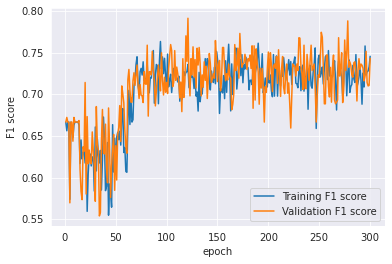

ROC-AUC Score: 0.734261186264308
F1 Score: 0.7147766323024054
Precision Score: 0.734261186264308
Recall Score: 0.7147766323024054


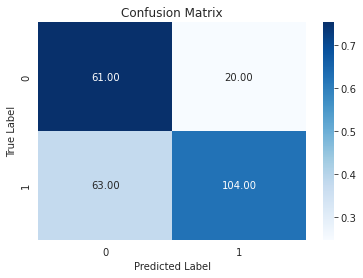

In [ ]:
G = nx.readwrite.gexf.read_gexf(graph_path)
test_size = int(round(len(G.edges())*0.1))

for n1, n2, d in G.edges(data=True):
    d.pop('id', None)
G = Graph(G)
dataset = GraphDataset([G],
        task='link_pred',
        edge_train_mode="disjoint"
    )
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
datasets['train']=datasets['train'].apply_transform(create_node_features_fn, update_tensor=False)
datasets['val']=datasets['val'].apply_transform(create_node_features_fn, update_tensor=False)
datasets['test']=datasets['test'].apply_transform(create_node_features_fn, update_tensor=False)
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

params = {
    'input_dim': input_dim,
    'hidden_dim' : args['hidden_dim'],
    'num_classes' : num_classes,
    'dropout': 0.3
}

model = gnn_factory.create_gnn('SAGE', params).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=10, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)

test_dataloader = DataLoader(
            datasets['test'], collate_fn=Batch.collate([]),
            batch_size=test_size, shuffle=False)
predict_eval(best_model, test_dataloader, args)



## GCNConv

/home/mk1/anaconda3/lib/python3.8/site-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/home/mk1/anaconda3/lib/python3.8/site-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/home/mk1/anaconda3/lib/python3.8/site-packages/deep

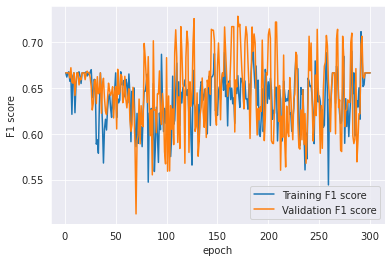

ROC-AUC Score: 0.7693808532778356
F1 Score: 0.7491638795986622
Precision Score: 0.7693808532778356
Recall Score: 0.7491638795986622


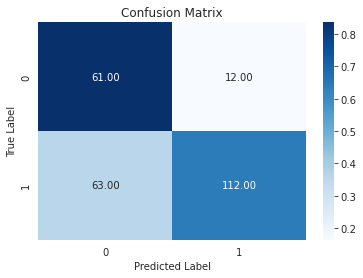

In [ ]:
model = gnn_factory.create_gnn('GCN', params).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=10, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)

test_dataloader = DataLoader(
            datasets['test'], collate_fn=Batch.collate([]),
            batch_size=test_size, shuffle=False)
predict_eval(best_model, test_dataloader, args)

## GATConv

/home/mk1/anaconda3/lib/python3.8/site-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/home/mk1/anaconda3/lib/python3.8/site-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/home/mk1/anaconda3/lib/python3.8/site-packages/deep

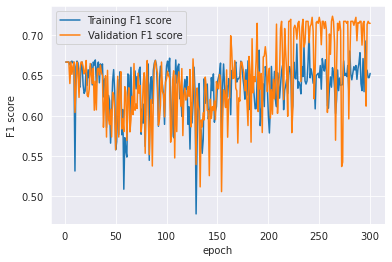

ROC-AUC Score: 0.6865244536940687
F1 Score: 0.7341772151898733
Precision Score: 0.6865244536940687
Recall Score: 0.7341772151898733


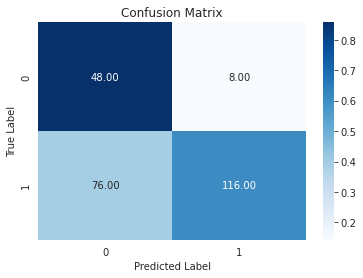

In [ ]:
model = gnn_factory.create_gnn('GAT', params).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=10, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)

test_dataloader = DataLoader(
            datasets['test'], collate_fn=Batch.collate([]),
            batch_size=test_size, shuffle=False)
predict_eval(best_model, test_dataloader, args)